<a href="https://colab.research.google.com/github/matthewshawnkehoe/Data-Analysis/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) by François Chollet. It contains runnable code blocks and section titles, and some text paragraphs, figures, and pseudocode and a bunch of edits made by Matthew Kehoe.


This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

A *timeseries* can be any data obtained via measurements at regular intervals, like the daily price of a stock, the hourly electricity consumption of a city, or the weekly sales of a store. Timeseries are everywhere, whether we're looking at natural phenomena (like seismic activity, the evolution of fish populations in a river, or the weather at a location) or human activity patterns (like visitors to a website, a country's GDP, or credit card transactions). Unlike the types of data you've encountered so far, working with timeseries involves understanding the dynamics of a system—its periodic cycles, how it trends over time, its regular regime and its sudden spikes.

By far, the most common timeseries-related task is *forecasting*: predicting what will happen next in a series. Although, there's actually a wide range of
other things you can do with timeseries:
* *Classification*—Assign one or more categorical labels to a timeseries. For instance, given the timeseries of the activity of a visitor on a website, classify whether the visitor is a bot or a human.
* *Event detection*—Identify the occurrence of a specific expected event within a continuous data stream. A particularly useful application is “hotword detection,” where a model monitors an audio stream and detects utterances like “Ok
Google” or “Hey Alexa.”
* *Anomaly detection*—Detect anything unusual happening within a continuous
datastream. Unusual activity on your corporate network? Might be an attacker.
Unusual readings on a manufacturing line? Time for a human to go take a look.
Anomaly detection is typically done via unsupervised learning, because you
often don't know what kind of anomaly you're looking for, so you can't train on
specific anomaly examples.

When working with timeseries, you'll encounter a wide range of domain-specific data-representation techniques. For instance, you have likely already heard about the Fourier transform, which consists of expressing a series of values in terms of a superposition of waves of different frequencies. The Fourier transform can be highly valuable when preprocessing any data that is primarily characterized by its cycles and oscillations (like sound, the vibrations of the frame of a skyscraper, or your brain waves). In the context of deep learning, Fourier analysis (or the related Mel-frequency analysis) and other domain-specific representations can be useful as a form of feature engineering,
a way to prepare data before training a model on it, to make the job of the model easier. However, we won't cover these techniques in these pages; we will instead focus on the modeling part.

In this chapter, you'll learn about recurrent neural networks (RNNs) and how to
apply them to timeseries forecasting

## A temperature-forecasting example

Throughout this chapter, all of our code examples will target a single problem: predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building. As you will see, it's a fairly challenging problem.

We'll use this temperature-forecasting task to highlight what makes timeseries data fundamentally different from the kinds of datasets you've encountered so far. You'll see that densely connected networks and convolutional networks aren't well-equipped to deal with this kind of dataset, while a different kind of machine learning technique—recurrent neural networks (RNNs)—really shines on this type of problem.

We'll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years.

Let's start by downloading and uncompressing the data:

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip    # download data from the web through wget
!unzip jena_climate_2009_2016.csv.zip

--2023-07-10 23:26:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.200.104, 54.231.172.56, 52.217.160.72, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.200.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  53.3MB/s    in 0.2s    

2023-07-10 23:26:10 (53.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Now let's look at the data.

**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)                                                                   # This outputs a count of 420,551 lines of data (each line is a timestep:                                                                                 # a record of a date and 14 weather-related values).
print(len(lines))                                                               # a record of a date and 14 weather-related values).

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the “Date Time” column.

**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]                                                  # We store column 1 in the “temperature” array.
    raw_data[i, :] = values[:]                                                  # We store all columns (including the temperature) in the “raw_data” array.

**Plotting the temperature timeseries**

The figure below shows the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature—the data spans 8 years.

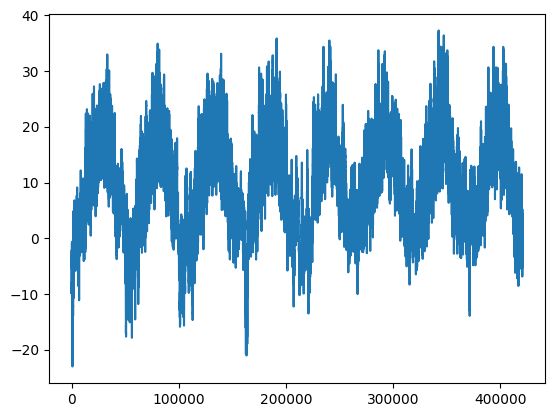

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

The next figure shows a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, you get 24 x 6 = 144 data points per day.

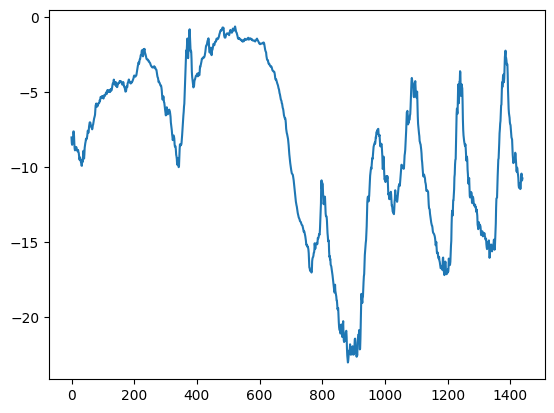

In [5]:
plt.plot(range(1440), temperature[:1440])

On this plot, you can see daily periodicity, especially for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

In all our experiments, we'll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it's important to use validation and test data that is more recent than the training data, because you're trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that.

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

First, let's preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don't need to do any vectorization. But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3). We'll normalize each timeseries independently so that they all take small values on a similar scale. We're going to use the first 210,225 timesteps as training data, so we'll compute the mean and standard deviation only on this fraction of the data.

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Instantiating datasets for training, validation, and testing**

Next, let's create a Dataset object that yields batches of data from the past five days along with a target temperature 24 hours in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their time steps in common), it would be wasteful to explicitly allocate memory for every sample. Instead, we'll generate the samples on the fly while only keeping in memory the original `raw_data` and `temperature` arrays, and nothing more.

We could easily write a Python generator to do this, but there's a built-in dataset utility in Keras that does just that (`timeseries_dataset_from_array()`), so we can save ourselves some work by using it. You can generally use it for any kind of timeseries forecasting task.

We'll use `timeseries_dataset_from_array()` to instantiate three datasets: one for training, one for validation, and one for testing.

We'll use the following parameter values:

* `sampling_rate = 6`—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
* `sequence_length = 120`—Observations will go back 5 days (120 hours).
* `delay = sampling_rate * (sequence_length + 24 - 1)`—The target for a sequence will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we'll pass `start_index = 0` and `end_index = num_train_samples` to only use the first 50% of the data. For the validation dataset, we'll pass `start_index = num_train_samples` and `end_index = num_train_samples + num_val_samples` to use the next 25% of the data. Finally, for the test dataset, we'll pass `start_index = num_train_samples + num_val_samples` to use the remaining samples.


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Each dataset yields a tuple `(samples, targets)`, where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like `samples[0]` and `samples[1]`) aren't necessarily temporally close.

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

Before we start using black-box deep learning models to solve the temperature-
prediction problem, let's try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that we'll have to beat in order to demonstrate the usefulness of more-advanced machine learning models. Such common-sense baselines can be useful when you're approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat.

In this case, the temperature timeseries can safely be assumed to be continuous
(the temperatures tomorrow are likely to be close to the temperatures today) as
well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the mean absolute error (MAE) metric, defined as follows:

`np.mean(np.abs(preds - targets))`

Here's the evaluation loop.

**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]                            # The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature
                                                                                # measurement in the input sequence. Recall that we normalized our features, so to
                                                                                # retrieve a temperature in degrees Celsius, we need to un-normalize it by multiplying
                                                                                # it by the standard deviation and adding back the mean.
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average. It's not too bad, but you probably won't launch a weather forecasting service based on this heuristic. Now the game is to use your knowledge of deep learning to do better.

### Let's try a basic machine-learning model

In the same way that it's useful to establish a common-sense baseline before trying machine learning approaches, it's useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

The following listing shows a fully connected model that starts by flattening the data and then runs it through two `Dense` layers. Note the lack of an activation function on the last Dense layer, which is typical for a regression problem. We use mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it's smooth around zero, which is a useful property for gradient descent. We will monitor MAE by adding it as a metric in `compile()`.

**Training and evaluating a densely connected model**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",                         # We use a callback to save the best-performing model.
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")                             # Reload the best model and evaluate it on the test data.
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 58s 69ms/step - loss: 13.9265 - mae: 2.8690 - val_loss: 13.1180 - val_mae: 2.8596
Epoch 2/10
819/819 [==============================] - 53s 64ms/step - loss: 9.2456 - mae: 2.3949 - val_loss: 10.1787 - val_mae: 2.5157
Epoch 3/10
819/819 [==============================] - 51s 62ms/step - loss: 8.4222 - mae: 2.2858 - val_loss: 11.9764 - val_mae: 2.7471
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 7.8968 - mae: 2.2137 - val_loss: 10.9488 - val_mae: 2.6174
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 7.5615 - mae: 2.1661 - val_loss: 12.6986 - val_mae: 2.8299
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 7.3209 - mae: 2.1316 - val_loss: 10.7109 - val_mae: 2.5916
Epoch 7/10
819/819 [==============================] - 58s 70ms/step - loss: 7.1583 - mae: 2.1074 - val_loss: 10.7559 - val_mae: 2.5927
Epoch 8/10
819/819 [==============================] - 

Let’s display the loss curves for validation and training below.

**Plotting results**

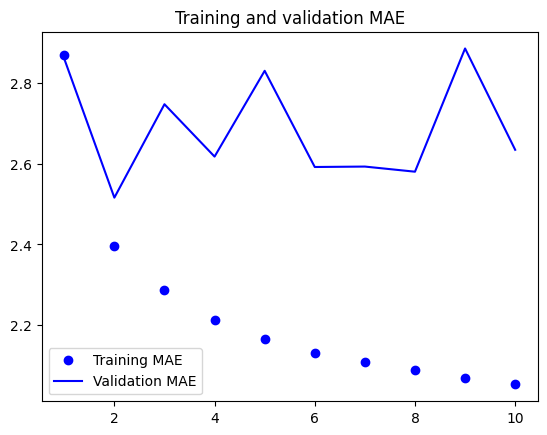

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Your common sense contains a lot of valuable information to which a machine learning model doesn't have access.

You may wonder, if a simple, well-performing model exists to go from the data to
the targets (the common-sense baseline), why doesn't the model you're training find it and improve on it? Well, the space of models in which you're searching for a solution—that is, your hypothesis space—is the space of all possible two-layer networks with the configuration you defined. The common-sense heuristic is just one model among millions that can be represented in this space. It's like looking for a needle in a haystack. Just because a good solution technically exists in your hypothesis space doesn't mean
you'll be able to find it via gradient descent.

That's a pretty significant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, it can sometimes fail to find a simple solution to a simple problem. That's why leveraging good feature engineering and relevant architecture priors is essential: you need to precisely tell your model what it should be looking for.

### Let's try a 1D convolutional model

Speaking of leveraging the right architecture priors, since our input sequences feature daily cycles, perhaps a convolutional model could work. A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.

Let's try one on our temperature-forecasting problem. We'll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via `MaxPooling1D` layers), we'll reduce the window size accordingly:

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 94s 113ms/step - loss: 22.3231 - mae: 3.7077 - val_loss: 19.0727 - val_mae: 3.4789
Epoch 2/10
819/819 [==============================] - 92s 112ms/step - loss: 15.7098 - mae: 3.1531 - val_loss: 17.5288 - val_mae: 3.3107
Epoch 3/10
819/819 [==============================] - 94s 115ms/step - loss: 14.2656 - mae: 3.0022 - val_loss: 17.7051 - val_mae: 3.3313
Epoch 4/10
819/819 [==============================] - 94s 114ms/step - loss: 13.3464 - mae: 2.9026 - val_loss: 19.7872 - val_mae: 3.5288
Epoch 5/10
819/819 [==============================] - 92s 112ms/step - loss: 12.6760 - mae: 2.8262 - val_loss: 16.2014 - val_mae: 3.1905
Epoch 6/10
819/819 [==============================] - 90s 109ms/step - loss: 12.1407 - mae: 2.7613 - val_loss: 15.2368 - val_mae: 3.0742
Epoch 7/10
819/819 [==============================] - 96s 117ms/step - loss: 11.7536 - mae: 2.7147 - val_loss: 15.7748 - val_mae: 3.1302
Epoch 8/10
819/819 [=====================

Remark: [Global Average Pooling Layers for Object Localization ](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/)

We get the training and validation curves shown in the figure below.

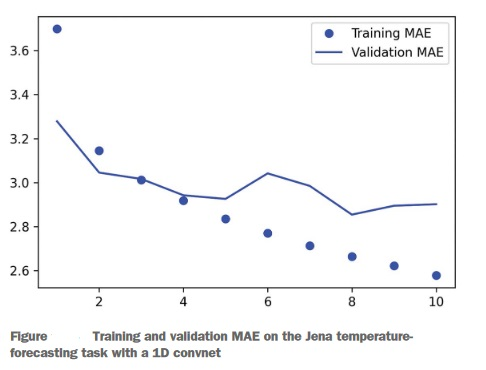

As it turns out, this model performs even worse than the densely connected one,
only achieving a validation MAE of about 2.9 degrees, far from the common-sense
baseline. What went wrong here? Two things:

*   First, weather data doesn't quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
*   Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day's temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.



### A first recurrent baseline

Neither the fully connected approach nor the convolutional approach did well, but that doesn't mean machine learning isn't applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. Let's instead look at the data as what it is: a sequence, where causality and order matter.

There's a family of neural network architectures designed specifically for this use case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM) layer has long been very popular. We'll see in a minute how these models work, but let's start by giving the LSTM layer a try.

**A simple LSTM-based model**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 137s 164ms/step - loss: 41.2442 - mae: 4.6930 - val_loss: 12.6803 - val_mae: 2.7063
Epoch 2/10
819/819 [==============================] - 132s 160ms/step - loss: 11.2660 - mae: 2.6063 - val_loss: 10.0052 - val_mae: 2.4504
Epoch 3/10
819/819 [==============================] - 133s 162ms/step - loss: 10.0846 - mae: 2.4775 - val_loss: 9.8301 - val_mae: 2.4154
Epoch 4/10
819/819 [==============================] - 134s 163ms/step - loss: 9.6415 - mae: 2.4174 - val_loss: 10.3844 - val_mae: 2.4768
Epoch 5/10
819/819 [==============================] - 130s 158ms/step - loss: 9.3334 - mae: 2.3757 - val_loss: 10.3496 - val_mae: 2.4765
Epoch 6/10
819/819 [==============================] - 131s 159ms/step - loss: 9.0722 - mae: 2.3404 - val_loss: 10.0510 - val_mae: 2.4385
Epoch 7/10
819/819 [==============================] - 113s 137ms/step - loss: 8.8011 - mae: 2.3082 - val_loss: 9.7643 - val_mae: 2.4186
Epoch 8/10
819/819 [====================

The figure below shows the results.

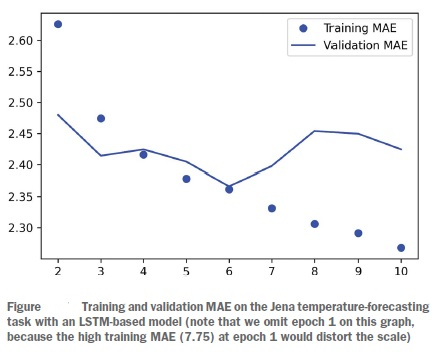

THe LSTM performs significantly better. We achieve a validation MAE as low as 2.36 degrees and a test MAE of 2.55 degrees. The LSTM-based model can finally beat the common-sense baseline (albeit just by a bit, for now), demonstrating the value of
machine learning on this task.

But why did the LSTM model perform markedly better than the densely connected
one or the convnet? And how can we further refine the model? To answer this, let's take a closer look at recurrent neural networks.

## Understanding recurrent neural networks

A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. For instance, this is what we did in the densely connected network example: we flattened our five days of data into a single large vector and processed it in one go. Such networks are called *feedforward networks*.

 In contrast, as you're reading the present sentence, you're processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence.

A *recurrent neural network* (RNN) adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a *state* that contains information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal *loop* (see figure below).

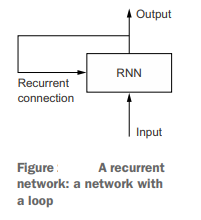

The state of the RNN is reset between processing two different, independent sequences (such as two samples in a batch), so you still consider one sequence to be a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.

To make these notions of *loop* and *state* clear, let's implement the forward pass of a toy RNN. This RNN takes as input a sequence of vectors, which we'll encode as a rank-2 tensor of size `(timesteps, input_features)`. It loops over timesteps, and at each timestep, it considers its current state at t and the input at `t` (of shape `(input_features,)`, and combines them to obtain the output at `t`. We'll then set the state for the next step
to be this previous output. For the first timestep, the previous output isn't defined; hence, there is no current state. So we'll initialize the state as an all-zero vector called the initial state of the network.

In pseudocode, this is the RNN.

**Pseudocode RNN**

In [16]:
state_t = 0                            # the state at t
for input_t in input_sequence:         # iterate over sequence elements
 output_t = f(input_t, state_t)
 state_t = output_t                    # The previous output becomes the state for the next iteration

NameError: ignored

You can even flesh out the function `f`: the transformation of the input and state into an output will be parameterized by two matrices, `W` and `U`, and a bias vector. It's similar to the transformation operated by a densely connected layer in a feedforward network.

**More-detailed pseudocode for the RNN**

In [ ]:
state_t = 0
for input_t in input_sequence:
 output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
 state_t = output_t

To make these notions absolutely unambiguous, let’s write a naive NumPy implementation of the forward pass of the simple RNN.

**NumPy implementation of a simple RNN**

In [17]:
import numpy as np
timesteps = 100                                                                 # Number of timesteps in the input sequence
input_features = 32                                                             # Dimensionality of the input feature space
output_features = 64                                                            # Dimensionality of the ouput feature space
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))                                          # Initial state: an all-zero vector
W = np.random.random((output_features, input_features))                         # Creates random weight matrices
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:                                                          # input_t is a vector of shape (input_features,).
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)             # Combines the input with the current state (the
                                                                                # previous output) to obtain the current output.
                                                                                # We use tanh to add non-linearity (we could use
                                                                                # any other activation function).

    successive_outputs.append(output_t)                                         # Stores this output in a list
    state_t = output_t                                                          # Updates the state of the network for the next timestep
final_output_sequence = np.stack(successive_outputs, axis=0)                    # The final output is a rank-2 tensor of shape (timesteps, output_features).

That's easy enough. In summary, an RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more. Of course, there are many different RNNs fitting this definition that you could build—this example is one of the simplest RNN formulations. RNNs are characterized by their step function, such as the following function in this case (see figure below).

`output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)`

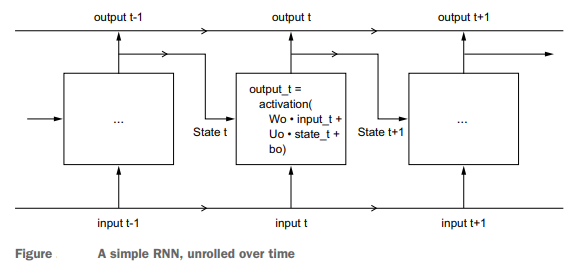

**Remark:** In this example, the final output is a rank-2 tensor of shape `(timesteps, output_features)`, where each timestep is the output of the loop at time `t`. Each timestep `t` in the output tensor contains information about timesteps 0 to t in the input sequence—about the entire past. For this reason, in many cases, you don't need this full sequence of outputs; you just need the last output (`output_t` at the end of the loop), because it already contains information about the entire sequence.

### A recurrent layer in Keras

The process we just naively implemented in NumPy corresponds to an actual Keras layer—the `SimpleRNN` layer.

There is one minor difference: SimpleRNN processes batches of sequences, like all other Keras layers, not a single sequence as in the NumPy example. This means it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps,input_features)`. When specifying the shape argument of the initial `Input()`, note that you can set the `timesteps` entry to `None`, which enables your network to process
sequences of arbitrary length.

**An RNN layer that can process sequences of any length**

In [18]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

This is especially useful if your model is meant to process sequences of variable length. However, if all of your sequences have the same length, I recommend specifying a complete input shape, since it enables `model.summary()` to display output length information, which is always nice, and it can unlock some performance optimizations.

All recurrent layers in Keras (`SimpleRNN`, `LSTM`, and `GRU`) can be run in two different modes: they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape `(batch_size, timesteps, output_features)`) or return only the last output for each input sequence (a rank-2 tensor of shape `(batch_size, output_features)`). These two modes are controlled by the return_sequences constructor argument. Let's look at an example that uses SimpleRNN and returns only the output at the last timestep.

**An RNN layer that returns only its last output step**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)                  # Note that return_sequences=False is the default.
print(outputs.shape)

(None, 16)


The following example returns the full state sequence.

**An RNN layer that returns its full output sequence**

In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


It's sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return a full sequence of outputs.

**Stacking RNN layers**

In [21]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In practice, you'll rarely work with the `SimpleRNN` layer. It's generally too simplistic to be of real use. In particular, `SimpleRNN` has a major issue: although it should theoretically be able to retain at time `t` information about inputs seen many timesteps before, such
long-term dependencies prove impossible to learn in practice. This is due to the *vanishing gradient problem*, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable. The theoretical reasons for this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s.

Thankfully, SimpleRNN isn't the only recurrent layer available in Keras. There are two others, *LSTM* and *GRU*, which were designed to address these issues.

Let's consider the *LSTM* layer. The underlying Long Short-Term Memory (LSTM)  algorithm was developed by Hochreiter and Schmidhuber in 1997;
it was the culmination of their research on the vanishing gradient problem.

This layer is a variant of the `SimpleRNN` layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you're processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing. This should remind you of *residual connections*, which you learned about in chapter 9: it's pretty much the same idea.

To understand this process in detail, let's start from the `SimpleRNN` cell (see figure below). Because you'll have a lot of weight matrices, index the `W` and `U` matrices in the cell, with the letter `o` (`Wo` and `Uo`) for output.

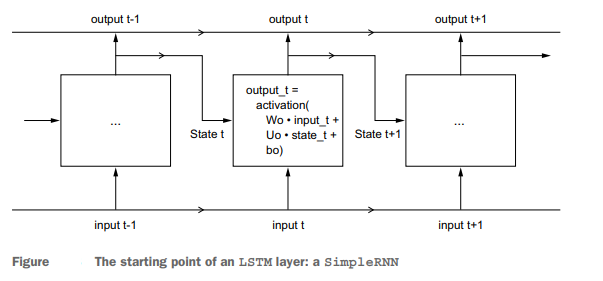

Let's add to this picture an additional data flow that carries information across timesteps. Call its values at different timesteps `c_t`, where C stands for *carry*. This information will have the following impact on the cell: it will be combined with the input connection and the recurrent connection (via a dense transformation: a dot product with a weight matrix followed by a bias add and the application of an activation function), and it will affect the state being sent to the next timestep (via an activation function and a multiplication operation). Conceptually, the carry dataflow is a way to modulate the next output and the next state (see figure below).

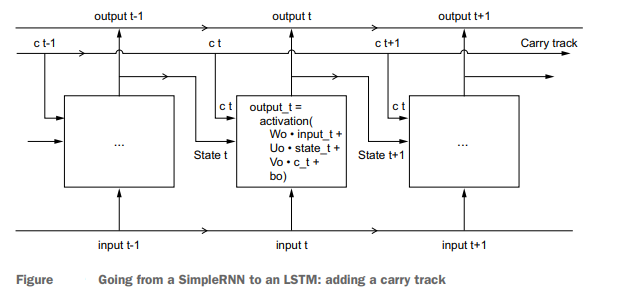

Now the subtlety—the way the next value of the carry dataflow is computed. It involves three distinct transformations. All three have the form of a `SimpleRNN` cell:

`y = activation(dot(state_t, U) + dot(input_t, W) + b)`

But all three transformations have their own weight matrices, which we’ll index with the letters `i`, `f`, and `k`. Here's what we have so far (it may seem a bit arbitrary, but bear with me).

**Pseudocode details of the LSTM architecture (1/2)**

In [ ]:
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

**Pseudocode details of the LSTM architecture (2/2)**

In [ ]:
c_t+1 = i_t * k_t + c_t * f_t

Add this as shown in the figure below, and that's it. Not so complicated—merely a tad complex.

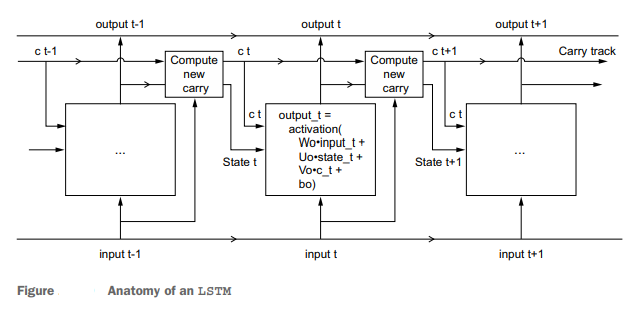

If you want to get philosophical, you can interpret what each of these operations is meant to do. For instance, you can say that multiplying `c_t` and `f_t` is a way to deliberately forget irrelevant information in the carry dataflow. Meanwhile, `i_t` and `k_t` provide information about the present, updating the carry track with new information.

But at the end of the day, these interpretations don't mean much, because what these operations *actually* do is determined by the contents of the weights parameterizing them; and the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose. The specification of an RNN cell (as just described) determines your hypothesis space—the space in which you'll search for a good model configuration during training—but it doesn't determine what the cell does; that is up to the cell weights. The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of *constraints* on your search, not as a *design* in an engineering sense.

Arguably, the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement learning processes) than to human engineers. In the future, that's how we'll build our models. In summary: you don't need to understand anything about the specific architecture of an LSTM cell; as a human, it shouldn't be your job to understand it. Just keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

## Advanced use of recurrent neural networks

We'll now cover the following:
- *Recurrent dropout*—This is a variant of dropout, used to fight overfitting in recurrent layers.
- *Stacking recurrent layers*—This increases the representational power of the model
(at the cost of higher computational loads).
- *Bidirectional recurrent layers*—These present the same information to a recurrent
network in different ways, increasing accuracy and mitigating forgetting issues.

We'll use these techniques to refine our temperature-forecasting RNN.

### Using recurrent dropout to fight overfitting

Let's go back to the LSTM-based model we used in the previous section—our first model able to beat the common-sense baseline. If you look at the training and validation curves, it's evident that the model is quickly overfitting, despite only having very few units: the training and validation losses start to diverge considerably after a few epochs. You're already familiar with a classic technique for fighting this phenomenon: dropout, which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn't a trivial question.


It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2016, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. What's more, in order to regularize the representations formed by the recurrent gates of layers such as `GRU` and `LSTM`, a temporally
constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units. Let's add recurrent dropout to the LSTM layer of our first `LSTM` example and see how doing so impacts overfitting.

Thanks to dropout, we won't need to rely as much on network size for regularization, so we'll use an LSTM layer with twice as many units, which should, hopefully, be more expressive (without dropout, this network would have started overfitting right away—try it). Because networks being regularized with dropout always take much longer to fully converge, we'll train the model for five times as many epochs.

**Training and evaluating a dropout-regularized LSTM**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)                                                      # To regularize the Dense layer, we also add a Dropout layer
                                                                                # after the LSTM.
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/30
819/819 [==============================] - 250s 302ms/step - loss: 29.2007 - mae: 3.9717 - val_loss: 9.9132 - val_mae: 2.4477
Epoch 2/30
819/819 [==============================] - 235s 286ms/step - loss: 14.9514 - mae: 3.0055 - val_loss: 9.3833 - val_mae: 2.3820
Epoch 3/30
819/819 [==============================] - 237s 289ms/step - loss: 14.0288 - mae: 2.9071 - val_loss: 9.2358 - val_mae: 2.3666
Epoch 4/30
819/819 [==============================] - 234s 285ms/step - loss: 13.2744 - mae: 2.8280 - val_loss: 10.7585 - val_mae: 2.5647
Epoch 5/30
819/819 [==============================] - 247s 300ms/step - loss: 12.8758 - mae: 2.7827 - val_loss: 9.1542 - val_mae: 2.3541
Epoch 6/30
819/819 [==============================] - 240s 292ms/step - loss: 12.4004 - mae: 2.7323 - val_loss: 9.0932 - val_mae: 2.3440
Epoch 7/30
819/819 [==============================] - 240s 293ms/step - loss: 12.0699 - mae: 2.6943 - val_loss: 9.1675 - val_mae: 2.3505
Epoch 8/30
819/819 [====================

**Plotting results**

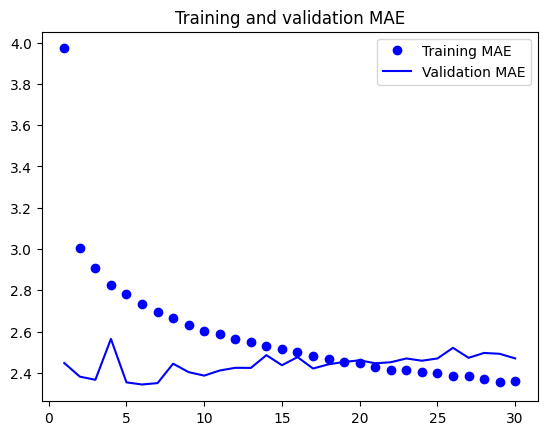

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The figure above shows the results. Success! We're no longer overfitting during the first 20 epochs. We achieve a validation MAE as low as 2.27 degrees (7% improvement over the no-learning baseline) and a test MAE of 2.45 degrees (6.5% improvement over the baseline). Not too bad.

**RNN Runtime Performance:** Recurrent models with very few parameters, like the ones in this chapter, tend to be significantly faster on a multicore CPU than on GPU, because they only involve small matrix multiplications, and the chain of multiplications is not well parallelizable due to the presence of a *for* loop. But larger RNNs can greatly benefit from a GPU runtime.

When using a Keras `LSTM` or `GRU` layer on GPU with default keyword arguments, your layer will be leveraging a cuDNN kernel, a highly optimized, low-level, NVIDIA-provided implementation of the underlying algorithm (I mentioned these in the previous chapter). As usual, cuDNN kernels are a mixed blessing: they're fast, but inflexible—if you
try to do anything not supported by the default kernel, you will suffer a dramatic slowdown, which more or less forces you to stick to what NVIDIA happens to provide. For instance, recurrent dropout isn't supported by the LSTM and GRU cuDNN kernels, so adding it to your layers forces the runtime to fall back to the regular TensorFlow implementation, which is generally two to five times slower on GPU (even though its computational cost is the same).

As a way to speed up your RNN layer when you can't use cuDNN, you can try *unrolling* it. Unrolling a `for` loop consists of removing the loop and simply inlining its content `N` times. In the case of the `for` loop of an RNN, unrolling can help TensorFlow optimize the underlying computation graph. However, it will also considerably increase the memory consumption of your RNN—as such, it's only viable for relatively small sequences (around 100 steps or fewer). Also, note that you can only do this if the
number of timesteps in the data is known in advance by the model (that is to say, if you pass a shape without any None entries to your initial `Input()`). It works like this:


**RNN Runtime**

In [24]:
inputs = keras.Input(shape=(sequence_length, num_features))                     # sequence_length cannot be None
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)                 # Pass unroll=True to enable unrolling.

### Stacking recurrent layers

Because you're no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity and expressive power of the network. Recall the description of the universal machine learning workflow: it's generally a good idea to increase the capacity of your model until overfitting becomes the primary obstacle (assuming you're already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren't overfitting too badly, you're likely under capacity.

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks: for instance, not too long ago the Google Translate algorithm was powered by a stack of seven large LSTM layers—that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a rank-3 tensor) rather than their output at the last timestep. As you've already learned, this is done by specifying `return_sequences=True`.

In the following example, we'll try a stack of two dropout-regularized recurrent layers. For a change, we'll use Gated Recurrent Unit (GRU) layers instead of LSTM. GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture. It was introduced in 2014 by Cho et al. when recurrent networks were just starting to gain interest anew in the then-tiny research community.

**Training and evaluating a dropout-regularized, stacked GRU model**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 444s 534ms/step - loss: 26.3404 - mae: 3.7726 - val_loss: 9.3867 - val_mae: 2.3646
Epoch 2/20
819/819 [==============================] - 436s 532ms/step - loss: 13.9795 - mae: 2.9025 - val_loss: 9.2764 - val_mae: 2.3614
Epoch 3/20
819/819 [==============================] - 437s 533ms/step - loss: 13.1734 - mae: 2.8134 - val_loss: 8.6610 - val_mae: 2.2785
Epoch 4/20
819/819 [==============================] - 433s 529ms/step - loss: 12.6121 - mae: 2.7554 - val_loss: 8.9396 - val_mae: 2.3206
Epoch 5/20
819/819 [==============================] - 396s 483ms/step - loss: 12.1207 - mae: 2.7012 - val_loss: 9.1435 - val_mae: 2.3514
Epoch 6/20
819/819 [==============================] - 402s 490ms/step - loss: 11.6654 - mae: 2.6503 - val_loss: 9.5390 - val_mae: 2.4096
Epoch 7/20
819/819 [==============================] - 440s 537ms/step - loss: 11.3113 - mae: 2.6101 - val_loss: 8.8709 - val_mae: 2.3221
Epoch 8/20
819/819 [=====================

The figure below shows the results. We achieve a test MAE of 2.39 degrees (an 8.8% improvement over the baseline). You can see that the added layer does improve the results a bit, though not dramatically. You may be seeing diminishing returns from increasing network capacity at this point.

**Plotting results**

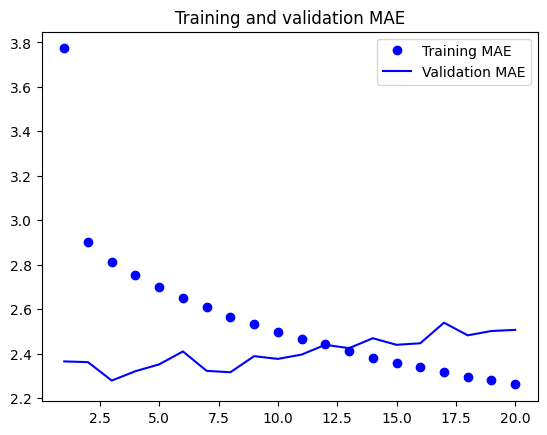

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Using bidirectional RNNs

The last technique we'll look at in this section is the *bidirectional RNN*. A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It's frequently used in natural language processing—you could call it the Swiss Army knife of deep learning for natural language processing.

RNNs are notably order-dependent: they process the timesteps of their input
sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely the reason they perform well on problems where order is meaningful, such as the temperature-forecasting problem. A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the GRU and LSTM layers you're already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

Remarkably, the fact that the RNN layers in this section have processed sequences in chronological order (with older timesteps first) may have been an arbitrary decision. At least, it's a decision we've made no attempt to question so far. Could the RNNs have performed well enough if they processed input sequences in antichronological order, for instance (with newer timesteps first)? Let's try this and see what happens. All you need to
do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets)`. Training the same LSTM-based model that you used in the first experiment in this section, you get the results shown in the figure below.

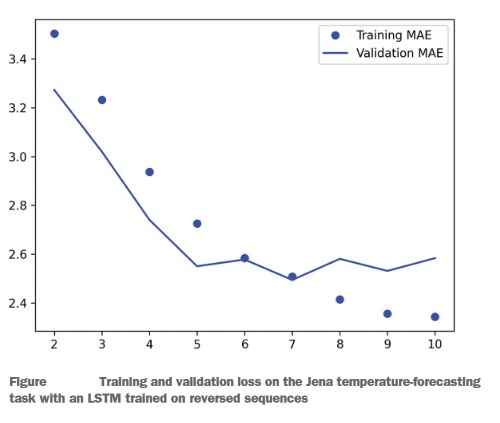

The reversed-order LSTM strongly underperforms even the common-sense baseline,
indicating that in this case, chronological processing is important to the success of the approach. This makes perfect sense: the underlying LSTM layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem (that's what makes the common-sense baseline fairly strong). Thus the chronological version of the layer is bound to outperform the reversed-order version.

However, this isn't true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence isn't usually dependent on its position in the sentence. On text data, reversed-order processing works just as well as chronological processing—you can read text backwards just fine (try it!). Although word order does matter in understanding language, *which order* you use isn't crucial.

Importantly, an RNN trained on reversed sequences will learn different representations than one trained on the original sequences, much as you would have different mental models if time flowed backward in the real world—if you lived a life where you died on your first day and were born on your last day. In machine learning, representations that are *different* yet useful are always worth exploiting, and the more they differ, the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can help boost performance on a task. This is the intuition behind *ensembling*, a concept we'll explore in chapter 13.

A bidirectional RNN exploits this idea to improve on the performance of
chronological-order RNNs. It looks at its input sequence both ways (see figure below), obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

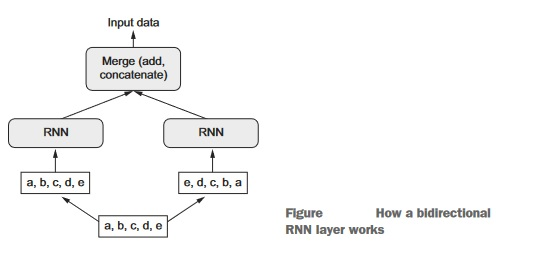

To instantiate a bidirectional RNN in Keras, you use the `Bidirectional` layer, which takes as its first argument a recurrent layer instance. `Bidirectional` creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order. You can try it on our temperature-forecasting task.

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

You'll find that it doesn't perform as well as the plain `LSTM` layer. It's easy to understand why: all the predictive capacity must come from the chronological half of the network, because the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past, in this case). At the same time, the presence of the antichronological half doubles the network's capacity and causes it to start overfitting much earlier.

However, bidirectional RNNs are a great fit for text data, or any other kind of data where order matters, yet where *which order* you use doesn't matter. In fact, for a while in 2016, bidirectional LSTMs were considered the state of the art on many natural language processing tasks (before the rise of the Transformer architecture, which you will learn about in the next chapter).

### Going even further

There are many other things you could try in order to improve performance on the
temperature-forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout. The current choices are largely arbitrary and thus probably suboptimal.
* Adjust the learning rate used by the `RMSprop` optimizer, or try a different
optimizer.
* Try using a stack of `Dense` layers as the regressor on top of the recurrent layer, instead of a single `Dense` layer
* Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.

As always, deep learning is more an art than a science. We can provide guidelines that suggest what is likely to work or not work on a given problem, but, ultimately, every dataset is unique; you'll have to evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must iterate.

In my experience, improving on the no-learning baseline by about 10% is likely
the best you can do with this dataset. This isn't so great, but these results make sense: while near-future weather is highly predictable if you have access to data from a wide grid of different locations, it's not very predictable if you only have measurements from a single location. The evolution of the weather where you are depends on current weather patterns in surrounding locations.

**Markets and machine learning**: Some readers are bound to want to take the techniques I've introduced here and try them on the problem of forecasting the future price of securities on the stock market (or currency exchange rates, and so on). However, markets have very different statistical characteristics than natural phenomena such as weather patterns. When it comes to markets, past performance is not a good predictor of future returns—looking in the rear-view mirror is a bad way to drive. Machine learning, on the other hand, is appli-
cable to datasets where the past is a good predictor of the future, like weather, electricity consumption, or foot traffic at a store.

Always remember that all trading is fundamentally *information arbitrage*: gaining an advantage by leveraging data or insights that other market participants are missing. Trying to use well-known machine learning techniques and publicly available data to beat the markets is effectively a dead end, since you won't have any information advantage compared to everyone else. You're likely to waste your time and resources with nothing to show for it.

## Summary

* As you first learned in chapter 5, when approaching a new problem, it's good to first establish common-sense baselines for your metric of choice. If you don't have a baseline to beat, you can't tell whether you're making real progress.
* Try simple models before expensive ones, to make sure the additional expense
is justified. Sometimes a simple model will turn out to be your best option.
* When you have data where ordering matters, and in particular for timeseries
data, *recurrent networks* are a great fit and easily outperform models that first flatten the temporal data. The two essential RNN layers available in Keras are the `LSTM` layer and the `GRU` layer.
* To use dropout with recurrent networks, you should use a time-constant drop-
out mask and recurrent dropout mask. These are built into Keras recurrent lay-
ers, so all you have to do is use the `recurrent_dropout` arguments of recurrent
layers.
* Stacked RNNs provide more representational power than a single RNN layer.
They're also much more expensive and thus not always worth it. Although they
offer clear gains on complex problems (such as machine translation), they may
not always be relevant to smaller, simpler problems.